# Analysis of Peptide Contact Map

In this notebook, we analyze an all-atom MD simulation of a peptide system in explicit solvent using `MDAnalysis` python pachage. We focus on extracting key structural and dynamic properties relevant for aggregation behavior and peptide phase behavior:

- Distance Map
- Contact Map

Trajectory: 50 ns with 500 ps timestep
System: 100 short disordered peptides in water and ion solution (water and ions are not present in the .xtc file)

In [82]:
import MDAnalysis as mda
import matplotlib.pyplot as plt
import numpy as np
from MDAnalysis.analysis import rms
import seaborn as sns
sns.set(style="white")

In [5]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from scripts import helpers as h

In [6]:
%load_ext autoreload
%autoreload 2

### Loading the trajectory

In [7]:
u, times, chains = h.init_trj('../data/initial.pdb','../data/pbc.md.xtc')

Trjectory of 101 frames of 50000.0 ps with a timestep of 500.0 ps
Box size: 57.0 57.0 116.910400390625 $\AA$
There is 9400 total atoms ( 100 chains each of 94 atoms )
Unique residues  ['ACE' 'GLN' 'GLY' 'NME' 'TYR']


In [8]:
nchains = len(chains)
nframes = len(times)

### Calculating distance matrix
We will use MDAnalysis to compute distance matrix between heavy atoms of our peptide

In [9]:
from MDAnalysis.lib import distances

<module 'MDAnalysis.lib.distances' from '/Users/lisabere/opt/anaconda3/lib/python3.8/site-packages/MDAnalysis/lib/distances.py'>

In [110]:
chains_hh = [chain.select_atoms('not name *H*') for chain in chains]
nres = len(chains_hh[0])
print(f'There is {nres} heavy atoms in this peptide, unique once are : {np.unique(chains_hh[0].atoms.names)}')

There is 51 heavy atoms in this peptide, unique once are : ['C' 'CA' 'CB' 'CD' 'CD1' 'CD2' 'CE1' 'CE2' 'CG' 'CZ' 'N' 'NE2' 'O' 'OE1']


In [117]:
d_intra = np.zeros((nres,nres))
d_inter = np.zeros((nres,nres))

for ifr,frame in enumerate(u.trajectory[20:]):
    for i,chaini in enumerate(chains_hh):
        result = np.zeros((nres,nres))
        d_intra += distances.distance_array(chaini.positions,chaini.positions,box=u.dimensions,result=result)
        for j,chainj in enumerate(chains_hh[i+1:]):
            result = np.zeros((nres,nres))
            d_inter += distances.distance_array(chaini.positions,chainj.positions,box=u.dimensions,result=result)

In [118]:
d_intra_sc = d_intra/((nframes-20) * nchains)
d_inter_sc = d_inter/((nframes-20) * nchains * (nchains-1)/2)

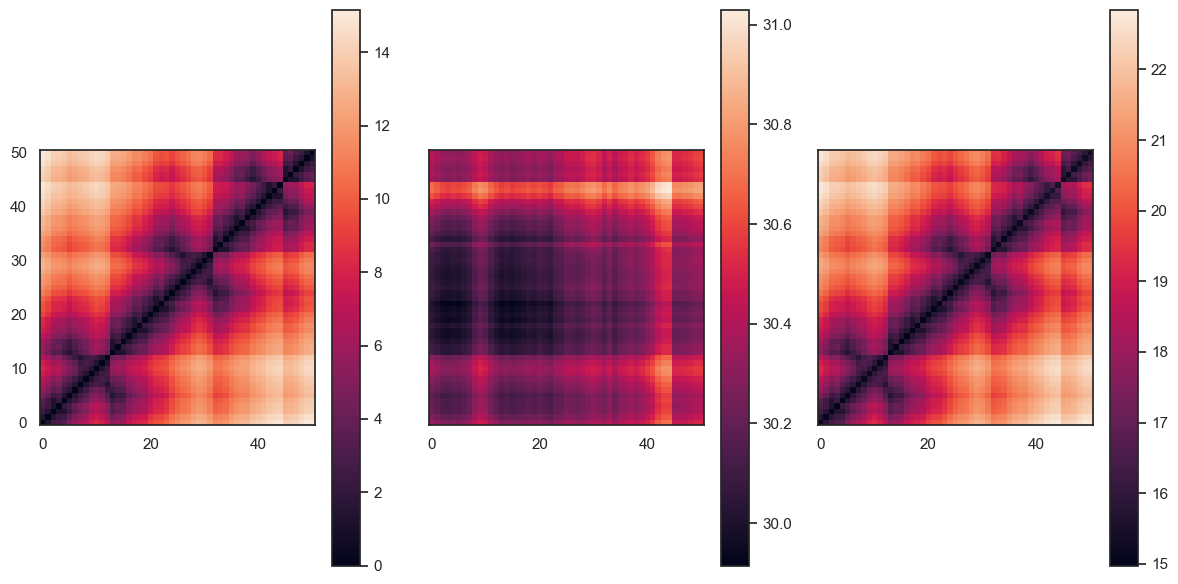

In [119]:
fig,axs = plt.subplots(1,3,figsize=(12,6),sharex=True,sharey=True)
d_intra_im = axs[0].imshow(d_intra_sc,origin='lower')
d_inter_im = axs[1].imshow(d_inter_sc,origin='lower')
d_tot_im = axs[2].imshow((d_inter_sc+d_intra_sc)/2,origin='lower')

plt.colorbar(d_intra_im)
plt.colorbar(d_inter_im)
plt.colorbar(d_tot_im)

plt.tight_layout()

In [114]:
d_inter_sc[0,1] - d_inter_sc[1,0]

0.030602354022221334